# Object detection model


To find coordinates of a circle center on the image with several geometric shapes. 

* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Selection of hyperparameters](#Selection-of-hyperparameters)
* [Training](#Training)
* [Inference](#Inference)
* [Model evaluation](#Model-evaluation)
* [Operating time](#Operating-time)
* [Criticism](#criticism)
* [Summary](#Summary)
* [Proposals for the improvement and further development](#Proposals-for-the-improvement-and-further-development)

In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

sys.path.insert(0, os.path.join("..", ".."))
from batchflow import Dataset, B, V, C, Pipeline
from batchflow.models.tf import ResNet18
from batchflow.research import Results

from src import ShapesBatch, show_samples, show_loss, show_research

# Dataset

For training and model performance assessment we generate images of shape 128x128 on which a circle and a square are randomly located.

A size and a position of a figure are generated independently:
- A Circle's diameter 2$r$ and a side of a square 2$r$ are randomly sampled from [10, 48].
- A position of figure's center is randomly sampled from [$r$, 128 - $r$].

A label data for every image is an array with circles center coordinates.

Data is generated on each iteration of training and test pipelines.
With respect to a number of iterations, there were generated 6000 images for training, 1000 images for testing.

Create a dataset as a template for a future generation of 1000 images:

In [1]:
imset = Dataset(1000, ShapesBatch)

Examples of dataset items.
Green dots on the images correspond to circles' centers from the labels data.

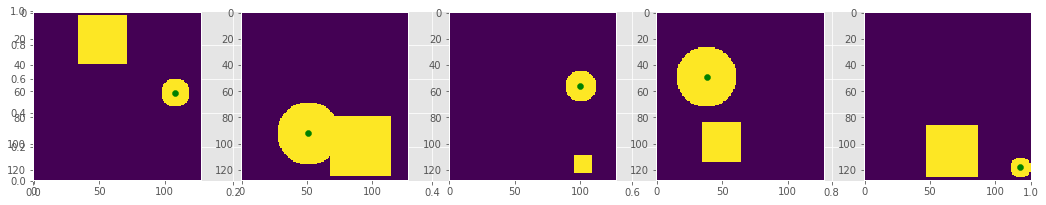

In [2]:
NUM_IMAGES = 5
batch = imset.next_batch(NUM_IMAGES).sample_images(128, max_r=24)
show_samples(batch.images[:, :, :, 0], p_true=batch.labels)

# Model architecture
We use model ResNet18 from ```batchflow.models.tf```

An architecture specification can be found at
[https://analysiscenter.github.io/batchflow/api/batchflow.models.tf.resnet.html](https://analysiscenter.github.io/batchflow/api/batchflow.models.tf.resnet.html)

Model config:

In [3]:
model_config={'inputs/images/shape': B("image_shape"),
              'inputs/labels/shape': 2,
              'initial_block/inputs': 'images',
              'loss': 'mse',
              'optimizer': 'Adam',
             }

# Selection of hyperparameters

Within the framework of the chosen model and the standard set of parameters for the optimizer, it is of interest to study the influence of the size of the batch on the rate of convergence of the solution.

As shown by [research](./parameters_estimation.ipynb) among the set [20, 50, 100], the size of the batch 100 is optimal. The graphs of the loss function and the metric are shown below, depending on the number of iterations for different batch sizes.

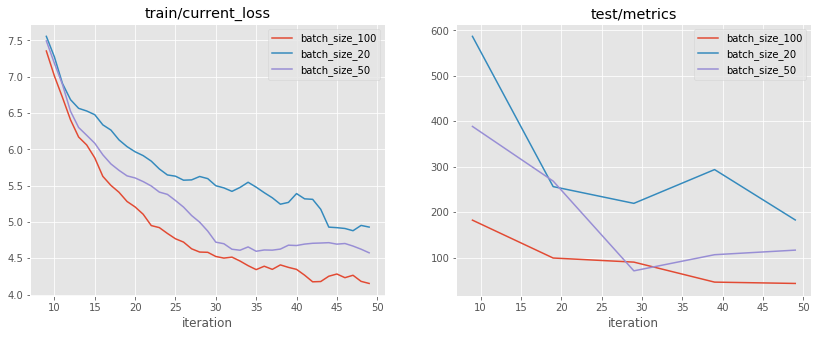

In [4]:
df = Results(path="parameters_research").load(use_alias=True)

show_research(df, layout=['train/current_loss', 'test/metrics'],
              average_repetitions=True, log_scale=[True, False],
              rolling_window=[10, None])

We can see that the size of the batch 100 shows a more stable convergence with better accuracy than the size of the batch of 20 or 50.

# Training

We train our model using stochastic gradient descent. On each iteration we
* generate mini-batch data
* update the weights 

Algorith of weights update (optimizer) is Adam with standard hyperparameters:
* ```learning_rate``` = 0.01
* ```beta1``` = 0.9
* ```beta2``` = 0.999
* ```epsilon``` = 1e-08.

Loss function - MSE (mean squared error).

Схема обхода датасета:
* ```batch_size``` = 100
* количество итераций = 60.

Dataset bypass:
* ```batch_size``` = 100
* ```n_iterations``` = 60.

Training pipeline:

In [5]:
train_template = (Pipeline()
                  .init_variable('loss_history', init_on_each_run=list)
                  .init_model('dynamic', ResNet18, 'resnet', config=model_config)
                  .sample_images(128, max_r=24)
                  .train_model('resnet', fetches='loss', images=B('images'), labels=B('labels'), 
                               save_to=V('loss_history', mode='a'))
                  .run_later(batch_size=100, n_epochs=6, drop_last=True, bar=True))

Execute training with batch size 100

In [6]:
train_pipeline = (train_template << imset).run()

 98%|█████████▊| 59/60 [11:16<00:10, 10.84s/it]


The loss function vs a number of iterations:

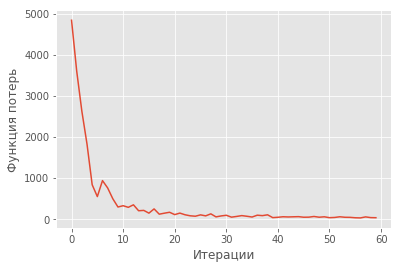

In [7]:
show_loss(train_pipeline.get_variable('loss_history'))

# Inference

Predict pipeline:

In [8]:
predict_template = (Pipeline()
                    .import_model('resnet', train_pipeline)
                    .init_variable('predictions', init_on_each_run=list)
                    .predict_model('resnet', fetches='predictions', images=B('images'),
                                   save_to=V('predictions', mode='e')))

Precreate data for test:

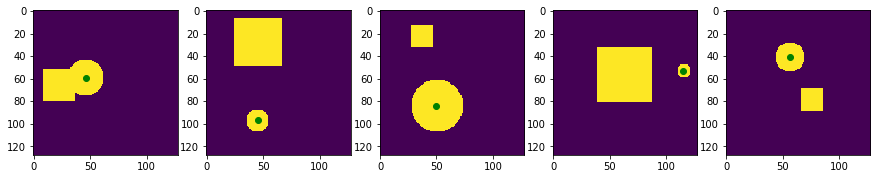

In [9]:
src_batch = (Dataset(NUM_IMAGES, ShapesBatch)
             .next_batch(NUM_IMAGES)
             .sample_images(128, circles=1, squares=1, max_r=24))

show_samples(src_batch.images[:, :, :, 0], src_batch.labels)

Execute predict pipeline:

In [10]:
predict_pipeline = ((predict_template << Dataset(size, ShapesBatch, preloaded=src_batch._data))
                    .run(100, shuffle=False, n_epochs=1, drop_last=False, bar=True))

  0%|          | 0/1 [00:00<?, ?it/s]


Let's see the initial images with the true centers (green dots) and the predicted centers (red dots).

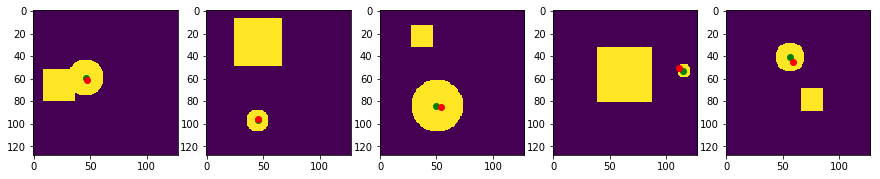

In [11]:
y_pred = np.stack(predict_pipeline.get_variable('predictions'))

show_samples(src_batch.images[:, :, :, 0], src_batch.labels, y_pred)

# Model evaluation

Quality metric, in this case, is Mean Squarred Error on the test set containing of 1000 images.

Metric evaluation pipeline:

In [12]:
test_template = (Pipeline()
                 .import_model('resnet', train_pipeline)
                 .init_variable('images', init_on_each_run=list)
                 .init_variable('predictions', init_on_each_run=list)
                 .init_variable("targets", init_on_each_run=list)
                 .sample_images(128, circles=C("circles"), squares=C("squares"), max_r=24)
                 .update_variable("images", B('images'), mode='e')
                 .update_variable("targets", B('labels'), mode='e')
                 .predict_model('resnet', fetches='predictions', images=B('images'),
                                save_to=V('predictions', mode='e')))

Execute test pipeline:

In [13]:
test_pipeline = ((test_template << imset).set_config(dict(circles=1, squares=1))
                 .run(100, shuffle=False, n_epochs=1, drop_last=False, bar=True))

 90%|█████████ | 9/10 [00:23<00:02,  2.90s/it]


Compute metric:

In [14]:
y_pred = np.stack(test_pipeline.get_variable('predictions'))
y_true = np.stack(test_pipeline.get_variable('targets'))
print("MSE: %.3f" % mean_squared_error(y_true, y_pred))

MSE: 17.451


*The obtained mse may vary for independent launches of model training. It is useful, along with a point estimate, to obtain the distribution of the metric over N independent runs of the training procedure.*


Examples of test images with the true centers (green dots) and the predicted centers (red dots).

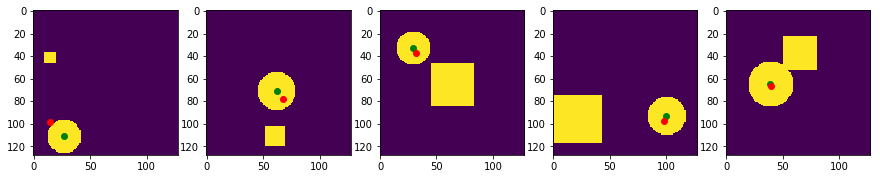

In [15]:
img = np.array(test_pipeline.get_variable('images'))

show_samples(img[:NUM_IMAGES, :, :, 0], y_true[:NUM_IMAGES], y_pred[:NUM_IMAGES])

# Operating time

Device: CPU i5.

One train step on batch size 100 takes 10 seconds. Training time is 10 minutes (60 iterations).

One image inference takes 26 ms, for batch size 1000 - 22 sec.

# Criticism

The model's mean squared error is 25. Error decreases to 10 if there are no squares on the images.


In [16]:
test_pipeline = ((test_template << imset).set_config(dict(circles=1, squares=0))
                 .run(100, shuffle=False, n_epochs=1, drop_last=False, bar=True))

y_pred = np.stack(test_pipeline.get_variable('predictions'))
y_true = np.stack(test_pipeline.get_variable('targets'))
print("MSE: %.3f" % mean_squared_error(y_true, y_pred))

 90%|█████████ | 9/10 [00:22<00:02,  2.76s/it]


MSE: 10.369


Examples of test images with the true centers (green dots) and the predicted centers (red dots).

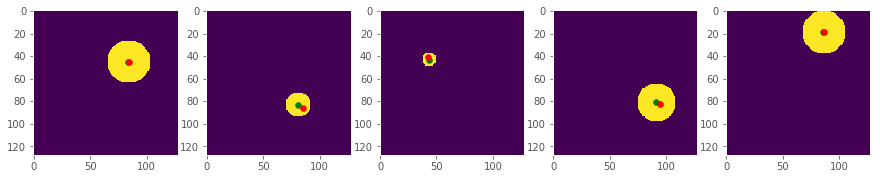

In [17]:
img = np.array(test_pipeline.get_variable('images'))

show_samples(img[:NUM_IMAGES, :, :, 0], y_true[:NUM_IMAGES], y_pred[:NUM_IMAGES])

Create an array of distances between the true and predicted center of the figures:

In [18]:
errs = ((y_true - y_pred) ** 2).sum(axis=1)

Construct a histogram of the distribution of errors. It behaves as expected:

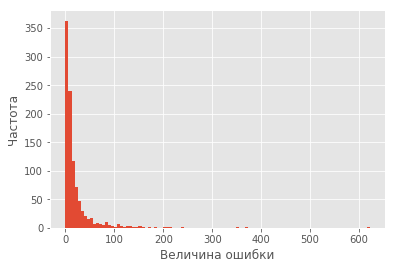

In [19]:
plt.hist(errs, bins=100)
plt.xlabel("Error"), plt.ylabel("Frequency")
plt.show()

However, if the exact centers of the circles are plotted and the magnitude of the error is shown in color, the distribution is different from the expected uniform distribution. There is an area in which large errors are more common (red dots of darker color):

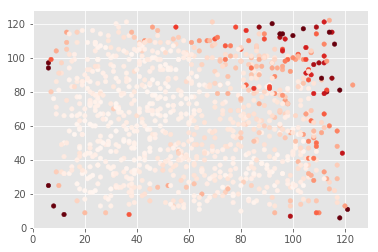

In [20]:
plt.scatter(y_true[:, 0], y_true[:, 1], c=np.clip(errs, 0, 150), cmap="Reds", s=20)
plt.show()

Thus, the error of the trained model is not uniformly distributed over the areas of the picture, which is not a completely desirable property for the model.

# Summary

The ResNet18 model showed an accuracy of 17.45 on the MSE metric. At the same time, the error of the trained model is not uniformly distributed over the areas of the picture.

# Proposals for the improvement and further development

It is necessary to check whether the detected behavior of the error of the trained model keeps place on several independently trained models. You can offer to try to significantly increase the number of iterations of training to improve the accuracy of the model.